<a href="https://colab.research.google.com/github/vperezguti/Resp-Experto-data---caso-practico/blob/main/Modelo2_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Plot Images
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

folder_dir = '/content/drive/MyDrive/Curso Data Science/mi_proyecto/images'
import random

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Curso Data Science/mi_proyecto/images'
img_height = 256
img_width = 256
batch_size = 32
    
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names

print(class_names)

Found 1148 files belonging to 10 classes.
Using 919 files for training.
Found 1148 files belonging to 10 classes.
Using 229 files for validation.
['Agaricus campestris', 'Amanita muscaria', 'Amanita phalloides', 'Boletus edulis', 'Lepista nuda', 'Macrolepiota procera', 'Marasmius oreades', 'Pleurotus ostreatus', 'Rubroboletus satanas', 'Tricholoma portentosum']


# Vamos a visualizar imágenes. 
Las primeras 9

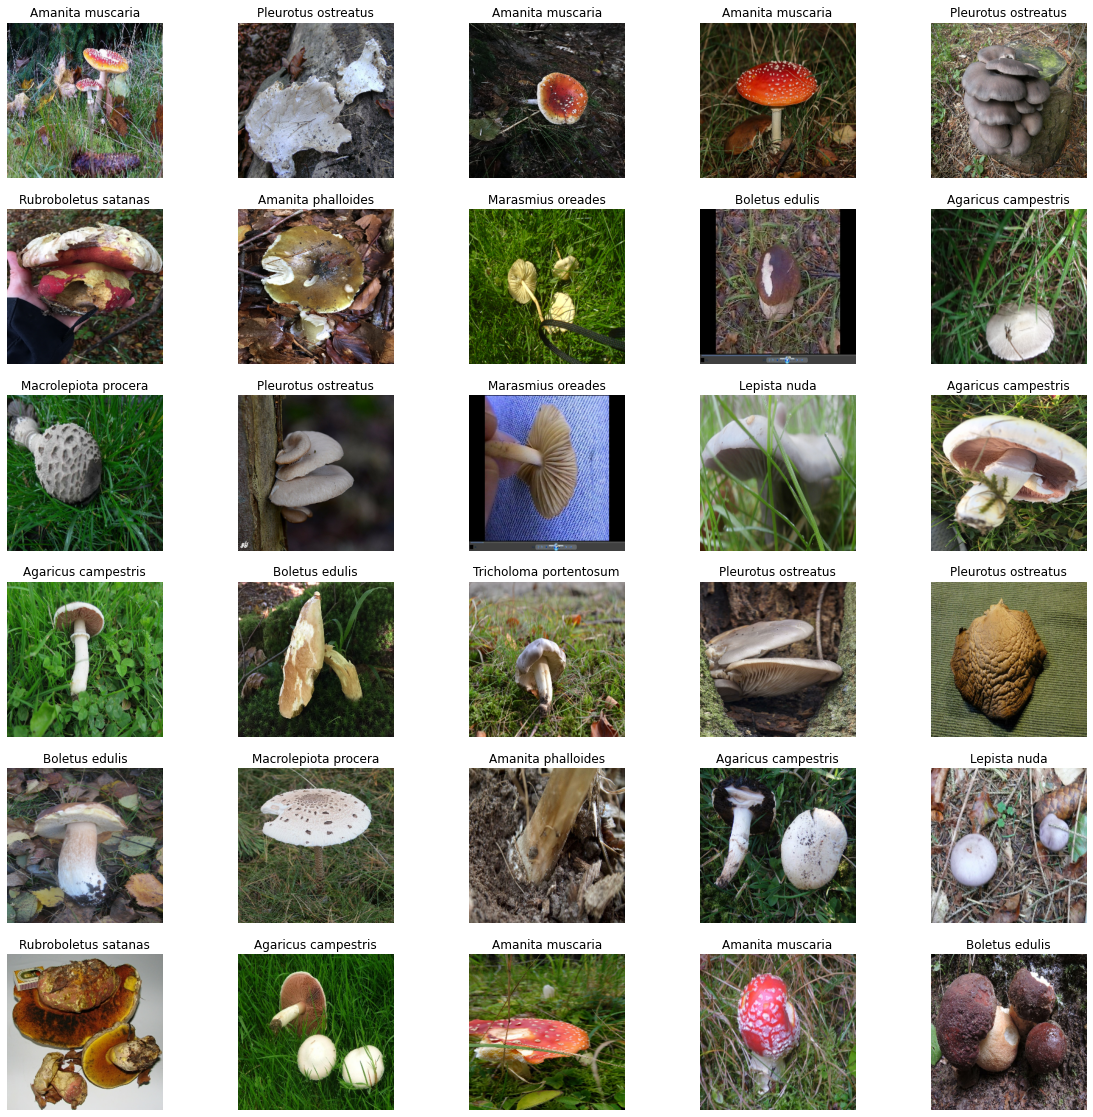

In [ ]:
plt.figure(figsize=(20,20))
for images,labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(6,5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Algunos ejemplos de predicción
Hemos buscado por internet algunas fotos para ver si qué tal predice


In [ ]:
# Creamos un diccionario con las fotos
datos_test = {'Agaricus campestris': 'https://www.mycodb.fr/photos/Agaricus_campestris_2003_dr_1.jpg', 
              'Macrolepiota Procera': 'https://www.mycodb.fr/photos/Macrolepiota_procera_2014_df_1.jpg', 
              'Amanita muscaria': 'https://www.mycodb.fr/photos/Amanita_muscaria_2005_ov_2.jpg', 
              'Amanita Phaloides': 'https://www.mycodb.fr/photos/Amanita_phalloides_2011_jpa_1.jpg', 
              'Boletus edulis': 'https://www.mycodb.fr/photos/Boletus_edulis_2007_ov_1.jpg', 
              'Lepista nuda': 'https://www.mycodb.fr/photos/Lepista_nuda_2019_db_1.jpg', 
              'Marasmius oreades': 'https://www.mycodb.fr/photos/Marasmius_oreades_2000_dr_1.jpg', 
              'Pleurotus ostreatus': 'https://www.mycodb.fr/photos/Pleurotus_ostreatus_2015_hm_1.jpg', 
              'Tricholoma portentosum': 'https://www.mycodb.fr/photos/Tricholoma_portentosum_2014_td_3.jpg', 
              'Rubroboletus satanas': 'https://www.mycodb.fr/photos/Rubroboletus_satanas_2006_ar_1.jpg'}

In [ ]:
#Crearemos una función para el cálculo 
def predict_seta(img_height, img_width, clases, modelo, img_url):
  img_path = tf.keras.utils.get_file('mushroom_image'+str(random.randint(0, 999)), origin=img_url)

  img = tf.keras.preprocessing.image.load_img(
      img_path, target_size=(img_height, img_width, 3)
  )

#plt.imshow(img)

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create a batch

  predictions = modelo.predict(img_array)

  predictions_sigmoid = tf.nn.sigmoid(predictions)
  score = tf.nn.softmax(predictions[0])

  return clases[np.argmax(score)], img

### MODELO 2

Lo primero será visualizar algunas imágenes

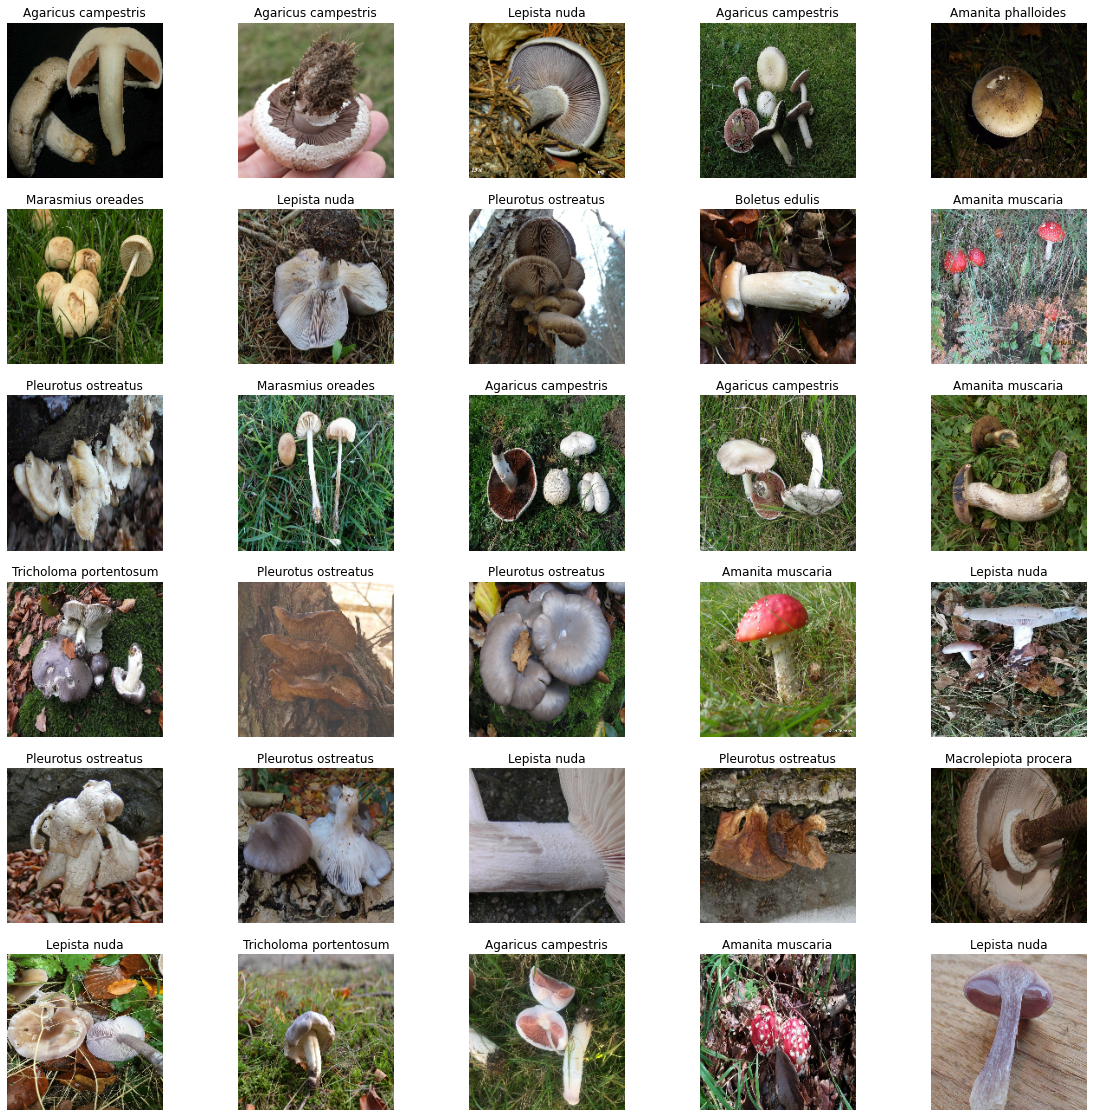

In [ ]:
plt.figure(figsize=(20,20))
for images,labels in train_ds.take(1):
  for i in range(30):
    ax = plt.subplot(6,5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Leemos el modelo**

In [ ]:
# Load the Model back from file
#import pickle
#Pkl_Filename = "Pickle_modelo2.pkl"  
#with open(Pkl_Filename, 'rb') as file:  
#    Pickled_LR_Model = pickle.load(file)

#Pickled_LR_Model

## Data Augmentation

In [ ]:
data_augmentation = Sequential([
    RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ])

Vamos a visualizar algunos ejemplos donde se ha aplicado el data augmentation a la misma imagen muchas veces

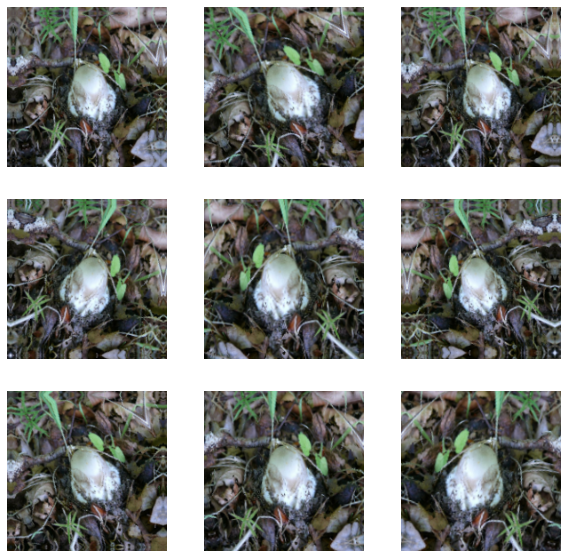

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout
Es otra técnica que reduce el overfitting. Al aplicar el dropout a una capa establece aleatoriamente las unidades de entrada en 0 con una frecuencia de rate en cada paso durante el tiempo de entrenamiento, lo que ayuda a evitar el sobreajuste. Las entradas que no se establecen en 0 se escalan en 1/(1 - tasa) de modo que la suma de todas las entradas no cambia.

In [ ]:
num_classes = len(class_names)

model2 = Sequential([
# Lo primero será aplicar el data autmentation    
  data_augmentation,
# Se realiza el reescaldo
  Rescaling(1./255),
# Primera capa convolucional, 16 filtros de salida, tamaño del kernel 3
# Función de activación ReLU
  Conv2D(16, 3, padding='same', activation='relu'),
# Capa de agrupación
  MaxPooling2D(),
# Segunda convolución, 32 filtros de salida  
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
# Segunda convolución, 64 filtros de salida  
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
# Capa Dropout, con parámetro 0.2 (se apaga aleatoriamente el 20%)  
  Dropout(0.2),
# Capa de aplanamiento  
  Flatten(),
# Capa densa  
  Dense(128, activation='relu'),
# Capa densa donde le indicamo el número de clases 
  Dense(num_classes, name="outputs")
])

## Compilamos el modelo 

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
epochs2=30
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs2
)

Epoch 1/30
29/29 [==============================] - 269s 4s/step - loss: 2.2984 - accuracy: 0.2089 - val_loss: 2.0910 - val_accuracy: 0.2926
Epoch 2/30
29/29 [==============================] - 68s 2s/step - loss: 1.9664 - accuracy: 0.3330 - val_loss: 1.9040 - val_accuracy: 0.3886
Epoch 3/30
29/29 [==============================] - 65s 2s/step - loss: 1.7493 - accuracy: 0.4091 - val_loss: 1.7919 - val_accuracy: 0.4061
Epoch 4/30
29/29 [==============================] - 65s 2s/step - loss: 1.6410 - accuracy: 0.4331 - val_loss: 1.7529 - val_accuracy: 0.3886
Epoch 5/30
29/29 [==============================] - 67s 2s/step - loss: 1.5803 - accuracy: 0.4429 - val_loss: 1.6866 - val_accuracy: 0.4454
Epoch 6/30
29/29 [==============================] - 66s 2s/step - loss: 1.4996 - accuracy: 0.4788 - val_loss: 1.6916 - val_accuracy: 0.4454
Epoch 7/30
29/29 [==============================] - 65s 2s/step - loss: 1.4439 - accuracy: 0.4886 - val_loss: 1.6879 - val_accuracy: 0.4498
Epoch 8/30
29/29 [=

## VISUALIZAR LOS RESULTADOS
Vamos a visualizar lor resultados

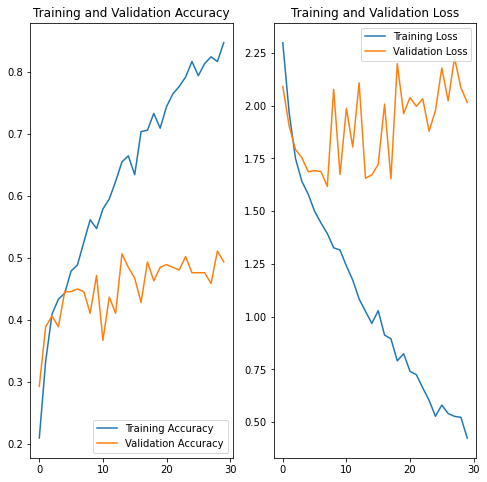

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range2 = range(epochs2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range2, acc2, label='Training Accuracy')
plt.plot(epochs_range2, val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range2, loss2, label='Training Loss')
plt.plot(epochs_range2, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1/1 [==============================] - 0s 31ms/step


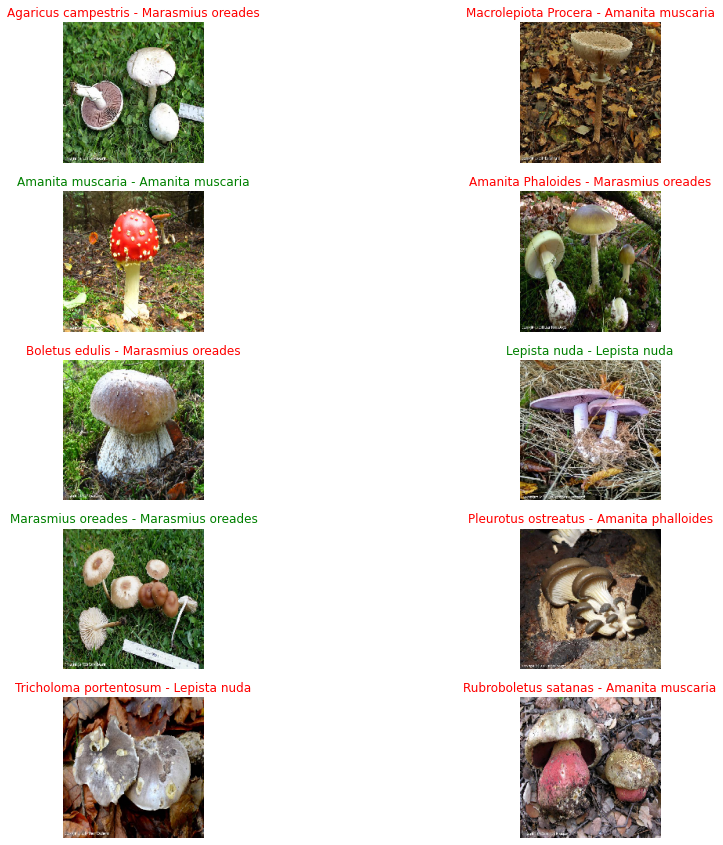

In [ ]:
predict_dict2 = {}
plt.figure(figsize=(15,15))
i = 1
for nombre, url in datos_test.items():
  prediccion2 = predict_seta(img_height, img_width, class_names, model2, url)
  predict_dict2[nombre] = prediccion2[0]
  ax = plt.subplot(5,2,i)
  plt.imshow(prediccion2[1])
  if nombre == prediccion2[0]:
    plt.title(nombre+" - "+prediccion2[0], color = 'g')
  else:  
    plt.title(nombre+" - "+prediccion2[0], color = 'r')
  plt.axis("off")
  i += 1
#print(predict_dict)

In [ ]:
#El siguiente código es para grabar el modelo
#import pickle
#Pkl_Filename = "Pickle_modelo2.pkl"  

#with open(Pkl_Filename, 'wb') as file:  
#    pickle.dump(model2, file)